In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import dlib
import imutils
from tensorflow.keras.preprocessing import image_dataset_from_directory
from scipy.spatial import Delaunay

In [2]:
def display_input_images(input_dir_path):
    input_images = image_dataset_from_directory(
        directory=input_dir_path, 
        color_mode='rgb', 
        batch_size=128, 
        image_size=(512,512), 
        label_mode=None,
        seed=42
    )

    show_image_num = 2
    images = list(input_images.take(1))[0]
    fig, axes = plt.subplots(nrows=1, ncols=show_image_num, figsize=(12, 6))

    for i in range(show_image_num):
        axes[i].imshow(images[i].numpy().astype("uint8"))
        axes[i].axis('off')
        axes[i].set_title(f'Input Image {i+1}')

    plt.tight_layout()
    plt.show()

Found 2 files.


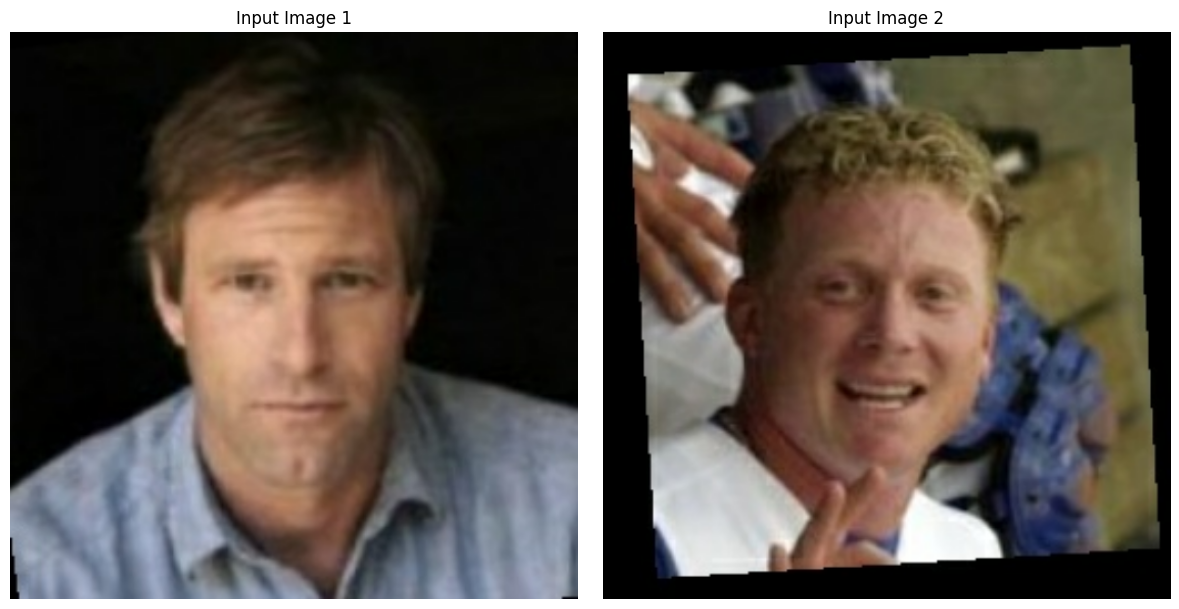

In [3]:
# Display input images

input_dir_path = 'io_face/input'
display_input_images(input_dir_path)

In [4]:
def load_img(path):
    image = cv2.imread(path)
    image = imutils.resize(image, width=512)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #cv2 loads images in BGR
    return image

In [5]:
def face_detect(image):
    # Detect face within image
    face_cascade = cv2.CascadeClassifier('models/haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(image, 1.3, 5)

    # To draw a rectangle in a face 
    for (x,y,w,h) in faces:
        cv2.rectangle(image,(x,y),(x+w,y+h),(255,255,0),2) 

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [6]:
def feature_detect(image):
    # Detect features within image
    predictor = dlib.shape_predictor('models/shape_predictor_68_face_landmarks.dat')
    detector = dlib.get_frontal_face_detector()
    try:
        detected_face = detector(image,1)[0]
    except:
        print('No face detected in image {}'.format(image))

    landmarks = predictor(image, detected_face)
    points = []

    for p in landmarks.parts():
        points.append([p.x, p.y])

    # Add 8 image frame coordinate points
    x = image.shape[1] - 1
    y = image.shape[0] - 1
    points.append([0, 0])
    points.append([x // 2, 0])
    points.append([x, 0])
    points.append([x, y // 2])
    points.append([x, y])
    points.append([x // 2, y])
    points.append([0, y])
    points.append([0, y // 2])

    return np.array(points)


def draw_features(image):
    img_points = feature_detect(image)
    img = image
    
    for idx, point in enumerate(img_points):
        pos = (point[0], point[1])
        cv2.putText(img,str(idx),pos,fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,fontScale=0.1,color=(0,255,0))
        
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [7]:
def get_triangles(points):
    return Delaunay(points).simplices

def affine_transform(input_image, input_triangle, output_triangle, size):
    warp_matrix = cv2.getAffineTransform(
        np.float32(input_triangle), np.float32(output_triangle))
    output_image = cv2.warpAffine(input_image, warp_matrix, (size[0], size[1]), None,
                                  flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
    return output_image

def merge_faces(img1, img2):
    points1 = feature_detect(img1)
    points2 = feature_detect(img2)
    # Calculate the average coordinates of points in two images

    alpha = 0.5
    points = (1 - alpha) * np.array(points1) + alpha * np.array(points2)
    triangles = get_triangles(points)

    img_morphed = np.zeros(img1.shape, dtype=img1.dtype)

    for i in triangles:
    
        # Calculate the frame of triangles
        x = i[0]
        y = i[1]
        z = i[2]

        tri1 = [points1[x], points1[y], points1[z]]
        tri2 = [points2[x], points2[y], points2[z]]
        tri = [points[x], points[y], points[z]]
        
        rect1 = cv2.boundingRect(np.float32([tri1]))
        rect2 = cv2.boundingRect(np.float32([tri2]))
        rect = cv2.boundingRect(np.float32([tri]))

        tri_rect1 = []
        tri_rect2 = []
        tri_rect_warped = []
        
        for i in range(0, 3):
            tri_rect_warped.append(((tri[i][0] - rect[0]), (tri[i][1] - rect[1])))
            tri_rect1.append(((tri1[i][0] - rect1[0]), (tri1[i][1] - rect1[1])))
            tri_rect2.append(((tri2[i][0] - rect2[0]), (tri2[i][1] - rect2[1])))
        
        # Accomplish the affine transform in triangles
        img1_rect = img1[rect1[1]:rect1[1] + rect1[3], rect1[0]:rect1[0] + rect1[2]]
        img2_rect = img2[rect2[1]:rect2[1] + rect2[3], rect2[0]:rect2[0] + rect2[2]]

        size = (rect[2], rect[3])
        warped_img1 = affine_transform(img1_rect, tri_rect1, tri_rect_warped, size)
        warped_img2 = affine_transform(img2_rect, tri_rect2, tri_rect_warped, size)
        
        # Calculate the result based on alpha
        img_rect = (1.0 - alpha) * warped_img1 + alpha * warped_img2

        # Generate the mask
        mask = np.zeros((rect[3], rect[2], 3), dtype=np.float32)
        cv2.fillConvexPoly(mask, np.int32(tri_rect_warped), (1.0, 1.0, 1.0), 16, 0)

        # Accomplish the mask in the merged image
        img_morphed[rect[1]:rect[1] + rect[3], rect[0]:rect[0] + rect[2]] = \
            img_morphed[rect[1]:rect[1] + rect[3], rect[0]:rect[0] +
                rect[2]] * (1 - mask) + img_rect * mask
        
    plt.imshow(img_morphed)
    plt.axis('off')
    plt.show()
    


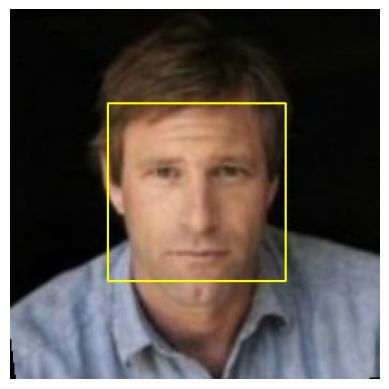

In [8]:
image = load_img(r'io_face/input/Aaron_Eckhart_0001.jpg')
face_detect(image)

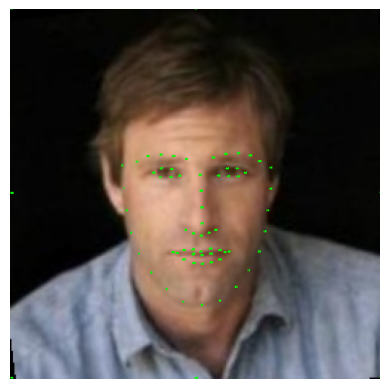

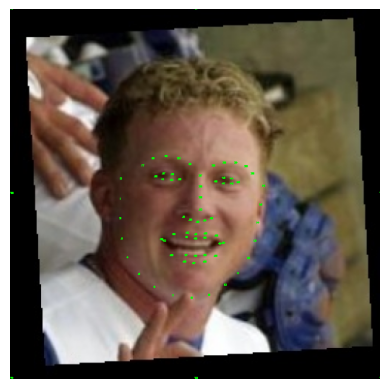

In [9]:
img1 = load_img(r'io_face/input/Aaron_Eckhart_0001.jpg')
img2 = load_img(r'io_face/input/Aaron_Guiel_0001.jpg')
draw_features(img1)
draw_features(img2)

The orininal image with Delaunay triangulation:


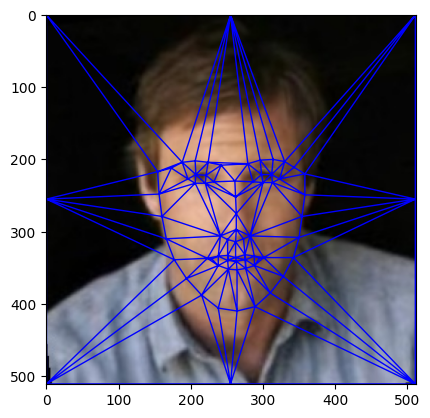

In [10]:
img1 = load_img(r'io_face/input/Aaron_Eckhart_0001.jpg')
points1=feature_detect(img1)
triangles1 = get_triangles(points1)
print ("The orininal image with Delaunay triangulation:")
plt.triplot(points1[:,0], points1[:,1], triangles1,linewidth=1,color='b')
plt.imshow(img1)
plt.show()

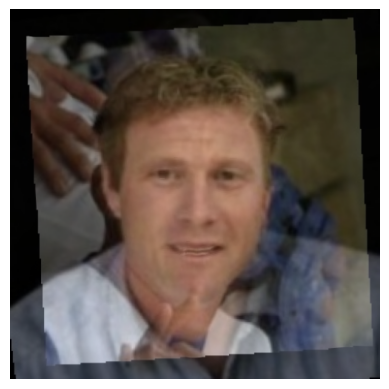

In [11]:
img1 = load_img(r'io_face/input/Aaron_Eckhart_0001.jpg')
img2 = load_img(r'io_face/input/Aaron_Guiel_0001.jpg')

merge_faces(img1, img2)